In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch

from collections import Counter
from scipy import special, optimize, stats
from scipy.stats import beta

# For parallelization
import multiprocessing 
import joblib

from conformal_utils import *
from fit_betas import beta_MoM
from utils.imagenet_helpers import ImageNetHierarchy

%load_ext autoreload
%autoreload 2

In [2]:
# # OPTION 1: Use ImageNet-val
# logits = torch.load('data/imagenet_val/logits.pt')
# labels = torch.load('data/imagenet_val/labels.pt')
# logits = logits.numpy()
# labels = labels.type(torch.LongTensor).numpy()

# OPTION 2: Use ImageNet-train
# logits = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_logits.pt', map_location=torch.device('cpu'))
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [3]:
## ONLY HAVE TO RUN THIS ONCE

# # Convert logits to softmax vectors (this takes a while)
# softmax_scores = special.softmax(logits, axis=1)
# torch.save(softmax_scores, 
#            '/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', 
#            pickle_protocol=4) # for saving large objects

### Some sanity checks

In [4]:
softmax_scores.shape
# With calib dataset only: (1140240, 1000)
# With calib+test dataset: (1153051, 1000)

(1153051, 1000)

In [5]:
labels.shape

(1153051,)

In [6]:
min(labels), max(labels)

(0, 999)

In [7]:
# Check the number of instances of each class
Counter(labels)

Counter({311: 1191,
         121: 1154,
         478: 1175,
         12: 1169,
         278: 1171,
         122: 1164,
         81: 1169,
         861: 1165,
         879: 1155,
         887: 1160,
         105: 1160,
         85: 1166,
         288: 1180,
         844: 1178,
         792: 1165,
         889: 1155,
         214: 1186,
         510: 1166,
         938: 1166,
         166: 927,
         634: 1164,
         409: 1174,
         928: 1171,
         117: 1198,
         821: 1029,
         733: 1170,
         509: 1160,
         338: 1178,
         626: 1184,
         629: 1153,
         555: 1160,
         972: 1181,
         878: 1165,
         782: 1147,
         739: 1161,
         347: 1184,
         546: 1181,
         914: 1095,
         548: 1164,
         812: 1112,
         476: 1157,
         462: 1173,
         342: 1155,
         595: 1167,
         615: 1167,
         776: 1160,
         108: 1167,
         591: 1152,
         314: 1174,
         281: 1168,
    

# Evaluate baseline methods

Use `num_calib` instances as calibration and the remaining as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [8]:
alpha = .1
num_calib = 50000

print(f'Desired coverage: {(1-alpha) * 100}%')
print(f'Number of calibration points: {num_calib} (roughly {num_calib / 1000:.0f} per class)')

Desired coverage: 90.0%
Number of calibration points: 50000 (roughly 50 per class)


In [9]:
n = len(labels)
scores = 1 - softmax_scores

In [10]:
%%time

np.random.seed(0)

# ======== SHUFFLE DATA ======== 
idx = np.random.permutation(np.arange(len(labels)))
shuffled_scores = scores[idx]
shuffled_labels = labels[idx]

CPU times: user 1.66 s, sys: 1min 10s, total: 1min 11s
Wall time: 1min 13s


In [11]:
%%time
# ======== SPLIT DATA ======== 
calib_scores, calib_labels = shuffled_scores[:num_calib], shuffled_labels[:num_calib]
val_scores, val_labels = shuffled_scores[num_calib:], shuffled_labels[num_calib:]

CPU times: user 1e+03 ns, sys: 18 µs, total: 19 µs
Wall time: 25 µs


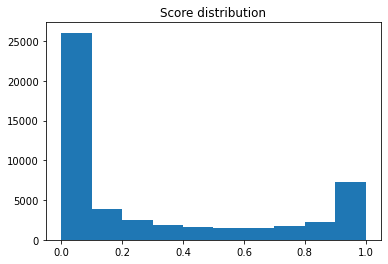

qhat: 0.9623951850664616
Standard conformal inference "marginal coverage": 89.75%


In [12]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# # print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
# plt.hist(class_specific_cov)
# plt.xlabel('Class coverage')
# plt.ylabel('Number of classes')
# plt.title('Distr. of class-specific coverage for each ImageNet class')
# plt.show()

In [13]:
# iii) Average set size
standard_avg_set_size = np.mean([len(arr) for arr in standard_ci_preds])
print(f'\nAverage size of vanilla conformal set: {standard_avg_set_size:.2f}')


Average size of vanilla conformal set: 1.88


<!-- One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference (practically, this works okay, but there is no theoretical guarantee). Another option is to set the quantile to $\infty$ (this is theoretically sound). -->

In [14]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = np.inf
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=default_qhat)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'\nClass-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# # print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
# plt.hist(cb_class_specific_cov)
# plt.xlabel('Class coverage')
# plt.ylabel('Number of classes')
# plt.title('Distr. of class-specific coverage for each ImageNet class')
# plt.show()


Class-balanced conformal inference "marginal coverage": 90.88%


In [15]:
# iii) Average set size
cb_avg_set_size = np.mean([len(arr) for arr in class_balanced_ci_preds])
print(f'\nAverage size of class-balanced conformal set: {cb_avg_set_size:.2f}')


Average size of class-balanced conformal set: 4.83


The analytical distribution of class-specific coverage is $$\frac{1}{K}\sum_{k=1}^K \mathsf{Beta}(\lceil(n_k+1)(1-\alpha)\rceil, n_k + 1 - \lceil(n_k+1)(1-\alpha)\rceil)$$
where $K$ is the total number of classes and $n_k$ is the number of times class $k$ appears in the calibration dataset.

In [16]:
# Get analytical distribution of true class coverages 
def get_analytical_class_cvg_distr(labels, alpha, grid=np.linspace(0, 1, 500)):
    
    # Count the number of instances of each class 
    class_cts = Counter(labels)
    class_cts = [class_cts[i] for i in range(len(class_cts))]

    distr = np.zeros(grid.shape)
    for k in range(len(class_cts)):
        a = np.ceil((class_cts[k] + 1) * (1 - alpha))
        b = class_cts[k] + 1 - a
        distr += beta.pdf(grid, a, b)
        
    distr /= len(class_cts)
    
    return distr

grid = np.linspace(0, 1, 500)
analytical_class_specific_cov_distr = get_analytical_class_cvg_distr(calib_labels, alpha, grid=grid)
# plt.plot(grid, analytical_class_specific_cov_distr)

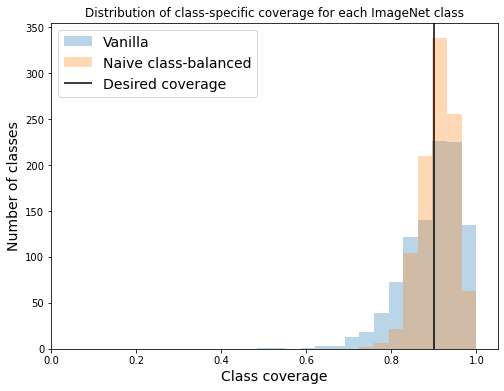

(Using 50000 calibration points) Number of classes that have less than 80% coverage using vanilla conformal: 90
(Using 50000 calibration points) Number of classes that have less than 80% coverage using naive class-balanced conformal: 11


In [17]:
## Plot
plt.figure(figsize=(8,6))

# Combine histograms into one plot
bins=np.linspace(0,1,30)

# # OPTION 1: Density
# plt.hist(class_specific_cov, bins=bins, label="Standard", alpha=.3, density=True)
# plt.hist(cb_class_specific_cov, bins=bins, label="Class-balanced", alpha=.3, density=True)

# # Plot analytical distribution if we assume we have an infinite amount of validation data
# plt.plot(grid, analytical_class_specific_cov_distr, label='Analytical (assuming infinite val set)')
# plt.ylabel('Density', fontsize=14)

# OPTION 2: Counts
plt.hist(class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
plt.hist(cb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)
plt.ylabel('Number of classes', fontsize=14)

# Plot desired coverages
bottom, top = plt.ylim()
plt.vlines(x=1-alpha, ymin=bottom, ymax=top, label="Desired coverage", color='black')

# Label plot
plt.xlabel('Class coverage', fontsize=14)
plt.title('Distribution of class-specific coverage for each ImageNet class')
plt.legend(loc='upper left', fontsize=14)
plt.ylim(bottom, top)
plt.xlim(left=0)
plt.show()

# Compute number of classes that are drastically undercovered (<80%)
vanilla_num_undercovered = np.sum(class_specific_cov < 0.8)
cb_num_undercovered = np.sum(cb_class_specific_cov < 0.8)
print(f'(Using {num_calib} calibration points) Number of classes that have less than 80% coverage using vanilla conformal:', vanilla_num_undercovered)
print(f'(Using {num_calib} calibration points) Number of classes that have less than 80% coverage using naive class-balanced conformal:', cb_num_undercovered)

In [18]:
qhats

array([0.27132053, 0.26631701, 0.93920828, 0.93078432, 0.81821731,
       0.9797715 , 0.95405456, 0.91214688, 0.8502826 , 0.10505826,
       0.65136986, 0.53402077, 0.59274788, 0.20723896, 0.14223185,
       0.23694442, 0.68026655, 0.87516033, 0.72036658, 0.80300765,
       0.97157322, 0.75875113, 0.19801503, 0.8992585 , 0.25941177,
       0.48705505, 0.99409977, 0.95842398, 0.58484886, 0.2720673 ,
       0.72915938, 0.62051693, 0.98849216, 0.9561843 , 0.90355486,
       0.99001272, 0.98888397, 0.66185749, 0.88717254, 0.95683967,
       0.87471461, 0.98942865, 0.71196076, 0.87295172, 0.92739161,
       0.11191082, 0.9591094 , 0.99282882, 0.05920668, 0.94770346,
       0.95291404, 0.69795192, 0.99526415, 0.91575193, 0.99736593,
       0.9596764 , 0.68757875, 0.46880697, 0.95398947, 0.92238308,
       0.99570338, 0.99741223, 0.99650941, 0.69331896, 0.94861008,
       0.99921181, 0.98259609, 0.89331793, 0.97975484, 0.42192815,
       0.27379837, 0.2394502 , 0.5126964 , 0.99885149, 0.98442

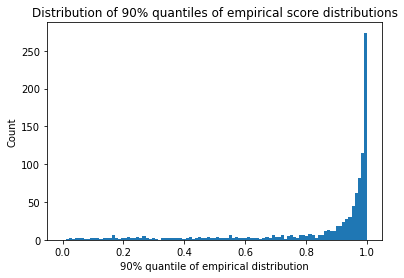

In [19]:
bins = np.linspace(0,1, 100)
plt.hist(qhats, bins=bins)
plt.xlabel('90% quantile of empirical distribution')
plt.ylabel('Count')
plt.title('Distribution of 90% quantiles of empirical score distributions')
plt.show()

In [20]:
np.mean(class_specific_cov), np.std(class_specific_cov)

(0.896929444061903, 0.06821078209701122)

In [21]:
np.mean(cb_class_specific_cov), np.std(cb_class_specific_cov)

(0.9087733379938365, 0.04044418913079073)

In [22]:
# class_balanced_ci_preds

In [23]:
# standard_ci_preds

# Fit Beta distribution to scores for each class $k$

[Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html) for scipy MLE and MoM parameter estimation. MLE minimizes negative log-likelihood function. MoM minimizes L2 norm of data moments and corresponding distribution moments.

n = 1037
Scipy MLE: 0.28691910728370695 0.5169111313659548
Scipy MoM: 6.620141466438003e-05 0.00013728351344916608
My MoM: 0.17646212528341843 0.3350552664962738


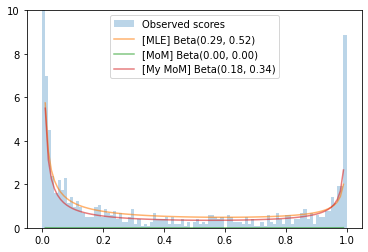

In [24]:
# First, let's do it for a single class

# Select data
k = 551
classk_scores = scores[labels==k,k]
print('n =', len(classk_scores))

# Fit distribution to data using MLE
a_k, b_k, _, _ = beta.fit(classk_scores, method='MLE')
print('Scipy MLE:', a_k, b_k)

# Fit distribution to data using scipy's MoM
a2_k, b2_k, _, _ = beta.fit(classk_scores, method='MM')
print('Scipy MoM:', a2_k, b2_k)

# Fit distribution to data using my MoM
a3_k, b3_k = beta_MoM(classk_scores)
print('My MoM:', a3_k, b3_k)


# Plot 
grid = np.linspace(0, 1, 100)
plt.hist(classk_scores, label='Observed scores', bins=grid, density=True, alpha=0.3) # Data

mle_fitted_distr = beta.pdf(grid, a_k, b_k)# MLE fitted distribution
plt.plot(grid, mle_fitted_distr, label= f'[MLE] Beta({a_k:.2f}, {b_k:.2f})', alpha=0.6)

mom_fitted_distr = beta.pdf(grid, a2_k, b2_k)# MoM fitted distribution
plt.plot(grid, mom_fitted_distr, label= f'[MoM] Beta({a2_k:.2f}, {b2_k:.2f})', alpha=0.6)

mom2_fitted_distr = beta.pdf(grid, a3_k, b3_k) # MoM fitted distribution
plt.plot(grid, mom2_fitted_distr, label= f'[My MoM] Beta({a3_k:.2f}, {b3_k:.2f})', alpha=0.6)


plt.legend()
plt.ylim(0,10)
plt.show()

In [25]:
# Sanity check that my MoM can correctly estimate the parameter values
a, b = 0.4, 10
print(f"True alpha, beta: {a}, {b}")

n = 100000
samples = np.random.beta(a,b, size=(n,))


est_a, est_b = beta_MoM(samples) 
print(f"[My MoM] Estimated alpha, beta: {est_a:.3f}, {est_b:.3f}")


est_a2, est_b2, _, _ = beta.fit(samples, method='MM')
print(f"[Scipy MoM] Estimated alpha, beta: {est_a2:.3f}, {est_b2:.3f}")

est_a3, est_b3, _, _ = beta.fit(samples, method='MLE')
print(f"[Scipy MLE] Estimated alpha, beta: {est_a3:.3f}, {est_b3:.3f}")

True alpha, beta: 0.4, 10
[My MoM] Estimated alpha, beta: 0.398, 9.996


/home/eecs/tiffany_ding/miniconda3/envs/env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/eecs/tiffany_ding/miniconda3/envs/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[Scipy MoM] Estimated alpha, beta: 0.518, 22.673
[Scipy MLE] Estimated alpha, beta: 0.393, 44.229


For skewed distributions (e.g., alpha=4, beta=10, my MoM does better than Scipy MoM and much better than Scipy MLE (which is very unstable))

In [26]:
classk_scores.mean(), classk_scores.std()

(0.34497777, 0.3866491)

In [27]:
beta.fit(classk_scores)

(0.28691910728370695,
 0.5169111313659548,
 3.671640804426117e-05,
 0.9999614637239377)

In [28]:
# %%time

# Note: The updated version of this code is located in fit_betas.py, which saves
# the estimated Beta parameters (est. using MoM) to 
# '/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/est_beta_params.npy'

# num_classes = 1000

# # BASE CODE
# beta_params_list = [beta.fit(scores[:,k])[:2] for k in range(num_classes)]

# # PARALLELIZED VERSION
# - using 24 cores, we can do 24 classes in 2 min
# num_cpus = 16 # multiprocessing.cpu_count()
# print(f'Splitting into {num_cpus} jobs...')

# def process(k):
#     return beta.fit(scores[:,k])[:2]

# beta_params_list = joblib.Parallel(n_jobs=num_cpus)(joblib.delayed(process)(k) for k in range(num_classes))

# # Save
# np.save('/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/est_beta_params.npy', beta_params)


In [29]:
beta_params = np.load('/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/est_beta_params.npy')

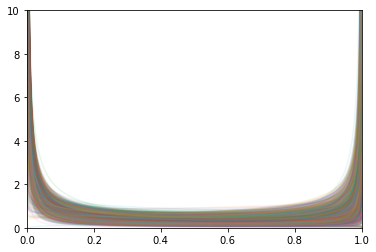

In [30]:
# Sanity check by plotting the Beta distributions corresponding to the estimated alpha, beta pairs
plot_grid = np.linspace(0,1,1000)
for i in range(len(beta_params)):
    plt.plot(plot_grid, beta.pdf(plot_grid, beta_params[i,0], beta_params[i,1]), alpha=0.1)
    
plt.ylim(bottom=0, top=10)
plt.xlim(0,1)
# plt.hist(scores, density=True)
plt.show()

In [31]:
# Investigate a class for which scores are right skewed (alpha/(alpha + beta) < 1/2)
right_skewed = np.argwhere(beta_params[:,0] / (beta_params[:,0] + beta_params[:,1]) > 0.5).flatten()
print(f'Number of classes with average score > 0.5: {len(right_skewed)}')
print('Right-skewed classes:', right_skewed)

Number of classes with average score > 0.5: 131
Right-skewed classes: [ 46  54  60  66  68  73  74  86 158 162 165 166 167 168 170 179 180 184
 185 189 192 204 227 230 231 238 240 241 242 248 250 257 265 266 278 281
 282 356 380 412 415 418 435 436 445 454 461 463 473 482 485 487 501 505
 524 526 527 536 542 567 578 582 585 587 596 600 618 619 620 623 626 631
 632 636 638 639 650 657 662 663 664 681 689 692 696 700 725 731 733 734
 742 744 748 754 764 767 782 784 799 804 809 810 813 817 818 824 836 837
 838 848 851 868 876 883 885 893 898 899 907 909 911 923 947 968 975 976
 977 978 987 998 999]


n = 1175


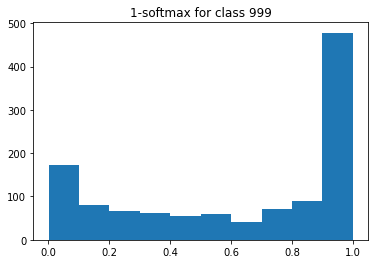

In [32]:
k = right_skewed[-1]
classk_scores = scores[labels==k,k]
print('n =', len(classk_scores))
plt.hist(classk_scores)
plt.title(f'1-softmax for class {k}')
plt.show()

### Plot distribution of estimated Beta parameters

In [33]:
# def beta_variance(alpha, beta):
#     '''
#     Implements variance formula for Beta distribution
#     '''
#     num = alpha * beta
#     denom = (alpha + beta)^2 * (alpha + beta + 1)
    
#     return num / denom

In [34]:
alpha =  beta_params[:,0]
beta = beta_params[:,1]
     
mean = alpha / (alpha+beta) 

num = alpha * beta
denom = (alpha + beta) ** 2 * (alpha + beta + 1)

variance = num/denom

(array([100., 171., 187., 195., 143.,  90.,  72.,  32.,   9.,   1.]),
 array([0.02163517, 0.10450307, 0.18737097, 0.27023887, 0.35310676,
        0.43597466, 0.51884256, 0.60171045, 0.68457835, 0.76744625,
        0.85031415]),
 <BarContainer object of 10 artists>)

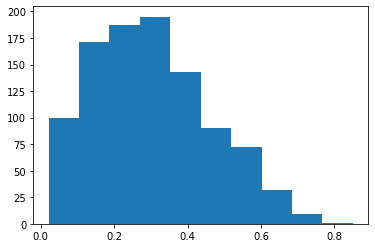

In [35]:
plt.hist(mean)

(array([  5.,  10.,  31.,  53.,  77.,  88., 182., 282., 224.,  48.]),
 array([0.11202566, 0.14418039, 0.17633512, 0.20848985, 0.24064458,
        0.27279932, 0.30495405, 0.33710878, 0.36926351, 0.40141824,
        0.43357298]),
 <BarContainer object of 10 artists>)

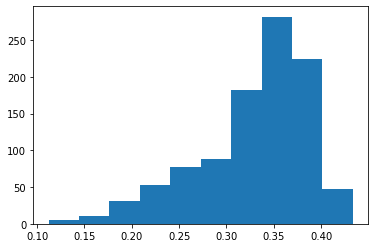

In [36]:
plt.hist(np.sqrt(variance))

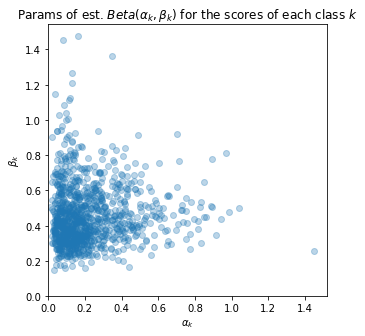

In [37]:
# Full plot
plt.figure(figsize=(5,5))
plt.scatter(beta_params[:,0], [beta_params[:,1]], alpha=0.3)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

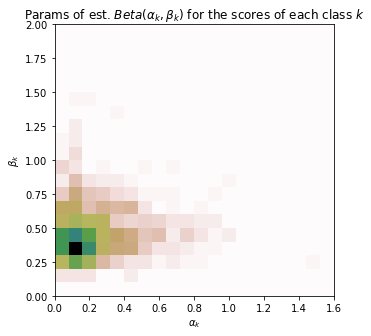

In [62]:
# x is the estimated alphas excluding the one that beta.fit failed on 
# y is the estimated betas excluding the one that beta.fit failed on 
x = beta_params[:,0]
# x = x[np.isfinite(x)]
y = beta_params[:,1]
# y = y[np.isfinite(y)]

xmin, xmax = 0, 1.6
ymin, ymax = 0, 2
bins = 20
plt.figure(figsize=(5,5))
cts, xedges, yedges, img = plt.hist2d(x, y, bins=bins, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.gist_earth_r)

plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

In [63]:
cts.max()

91.0

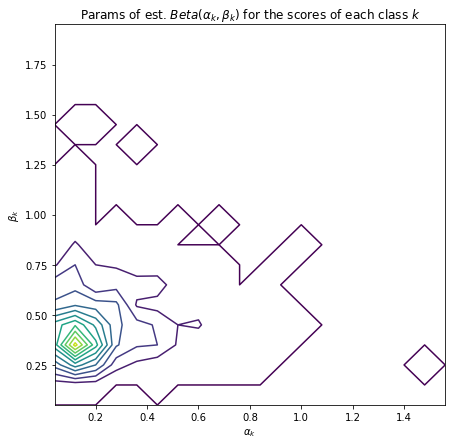

In [64]:
X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)

plt.figure(figsize=(7,7))
plt.contour(X, Y, cts.T, levels=12)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()
# plt.savefig('contout_plot.jpg')

### Apply KDE to smooth

In [65]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

#### Method 1

In [57]:
values = np.vstack([x, y])
kernel1 = stats.gaussian_kde(values)

#### Method 2

In [81]:
bins = 150
cts, xedges, yedges, img = plt.hist2d(x, y, 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

kernel2 = stats.gaussian_kde(positions, weights=cts.T.ravel())

#### Compare

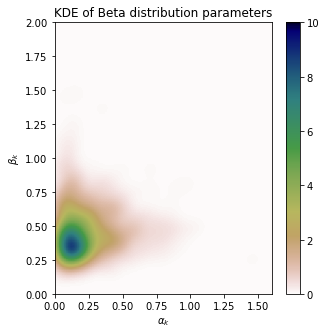

In [73]:
# Method 1
Z = np.reshape(kernel1(positions).T, X.shape).T
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, # Color map limits
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

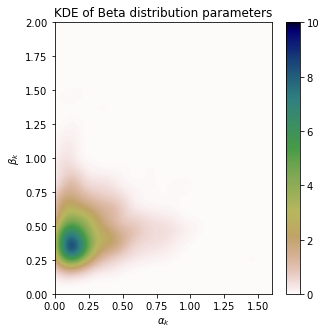

In [82]:
# Method 2
Z = np.reshape(kernel2(positions).T, X.shape).T
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, # Color map limits
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

#### Save KDE function
We will use this in `pipeline.ipynb` (at least, for now)

In [45]:
import os
import pickle
cwd = os.getcwd()

save_to = '.cache/kde.pkl'
with open(save_to, 'wb') as f:
    pickle.dump(kernel, f)
    
print(f'Saved KDE function to {cwd}/{save_to}')

Saved KDE function to /home/eecs/tiffany_ding/code/empirical-bayes-conformal/.cache/kde.pkl


### Fit 2D Gaussian to data

Model the Beta parameters as drawn from a Multivariate Gaussian:

$$\begin{bmatrix} \alpha_k \\ \beta_k \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix}, \begin{bmatrix} \sigma_{\alpha}^2 & \rho \\ \rho & \sigma_{\beta}^2 \end{bmatrix}\right)$$

data = beta parameters

In [34]:
def fit_2d_gaussian(data):
    '''
    Column 0 of data is x
    Column 1 of data is y
    '''
    mu_hat = np.mean(data, axis=0)
    sigma_hat = np.std(data, axis=0)
    corr_hat = np.mean(data[:,0] * data[:,1]) - mu_hat[0]*mu_hat[1]
    
    Sigma_hat = np.array([[sigma_hat[0], corr_hat], [corr_hat, sigma_hat[1]]])
    
    return mu_hat, Sigma_hat

In [35]:
# Sanity check using simulated data
mean = [5.5, 1.5]
cov = [[.9, .55], [.55, 1]]

n = 10000
samples = np.random.multivariate_normal(mean, cov, size=(n,))
fit_2d_gaussian(samples)

(array([5.5080045 , 1.50706893]),
 array([[0.95644836, 0.56882354],
        [0.56882354, 1.00880154]]))

Estimated mean: [0.22203217 0.4611614 ]
Estimated covariance matrix:
 [[0.18241718 0.00108726]
 [0.00108726 0.17464643]]


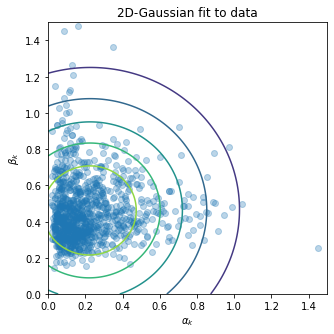

In [36]:
# Estimate multivariate normal parameters
mu_hat, Sigma_hat = fit_2d_gaussian(beta_params)
print('Estimated mean:', mu_hat)
print('Estimated covariance matrix:\n', Sigma_hat)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(beta_params[:,0], [beta_params[:,1]], alpha=0.3)

nx, ny = 200, 200
x = np.linspace(0, 1.5, nx)
y = np.linspace(0, 1.5, ny)
X,Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
gauss_pdf = stats.multivariate_normal.pdf(pos, mean=mu_hat, cov=Sigma_hat)
plt.contour(X,Y, gauss_pdf)

plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('2D-Gaussian fit to data')
plt.show()

In [57]:
# # Get 90% quantiles of fitted Betas
# quantiles = np.array([beta.ppf(1-alpha, beta_params[i,0], beta_params[i,1]) for i in range(len(beta_params))])
# plt.hist(quantiles, bins=20)
# plt.title("Distribution of 90% quantiles of fitted Betas")
# plt.xlabel("qhat")
# plt.ylabel("Count")
# plt.show()

In [37]:
# # Copied from https://scipy-cookbook.readthedocs.io/items/FittingData.html

# def gaussian(height, center_x, center_y, width_x, width_y):
#     """Returns a gaussian function with the given parameters"""
#     width_x = float(width_x)
#     width_y = float(width_y)
#     return lambda x,y: height*np.exp(
#                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

# def moments(data):
#     """Returns (height, x, y, width_x, width_y)
#     the gaussian parameters of a 2D distribution by calculating its
#     moments """
#     total = data.sum()
#     X, Y = np.indices(data.shape)
#     x = (X*data).sum()/total
#     y = (Y*data).sum()/total
#     col = data[:, int(y)]
#     width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
#     row = data[int(x), :]
#     width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
#     height = data.max()
#     return height, x, y, width_x, width_y

# def fitgaussian(data):
#     """Returns (height, x, y, width_x, width_y)
#     the gaussian parameters of a 2D distribution found by a fit"""
#     params = moments(data)
#     errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
#                                  data)
#     p, success = optimize.leastsq(errorfunction, params)
#     return p

In [38]:
# data = beta_params
# plt.scatter(beta_params[:,0], [beta_params[:,1]], alpha=0.3)
# # plt.matshow(data, cmap=plt.cm.gist_earth_r)

# params = fitgaussian(data)
# fit = gaussian(*params)

# plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
# ax = plt.gca()

### Compute 90% quantile of each Beta distribution

In [64]:
quantiles = np.array([beta.interval(0.9, beta_params[i,0], beta_params[i,1])[1] for i in range(len(beta_params))])

In [65]:
np.set_printoptions(suppress=True)
quantiles

array([0.8413976 , 0.58860101, 0.94577679, 0.98434339, 0.96998909,
       0.99660997, 0.94874877, 0.92364802, 0.95342574, 0.49079378,
       0.83462555, 0.68579488, 0.62276006, 0.68649833, 0.49212526,
       0.79582581, 0.55935847, 0.79544012, 0.88554868, 0.58638483,
       0.87464568, 0.91541744, 0.70588832, 0.90025941, 0.30036988,
       0.88684126, 0.98668888, 0.94785417, 0.91248521, 0.79394574,
       0.85467802, 0.88286216, 0.97361367, 0.97661178, 0.99896768,
       0.9915276 , 0.99494162, 0.89712977, 0.96100975, 0.94438208,
       0.92324493, 0.98435154, 0.94018469, 0.98681454, 0.98391046,
       0.59442559, 0.99779643, 0.78252544, 0.50898876, 0.9733481 ,
       0.92203141, 0.35929911, 0.99871034, 0.97069842, 0.99663966,
       0.99824031, 0.89079116, 0.85394792, 0.98813966, 0.96903019,
       0.99995764, 0.93911065, 0.99708414, 0.9532775 , 0.95869021,
       0.98831922, 0.99878491, 0.99501638, 0.98812269, 0.74580731,
       0.75537564, 0.78087528, 0.74735652, 0.99951   , 0.99853

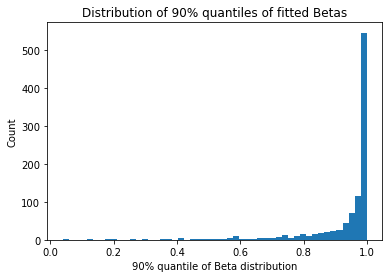

In [54]:
bins = 50
plt.hist(quantiles, bins=bins)
plt.xlabel('90% quantile of Beta distribution')
plt.ylabel('Count')
plt.title('Distribution of 90% quantiles of fitted Betas')
plt.show()

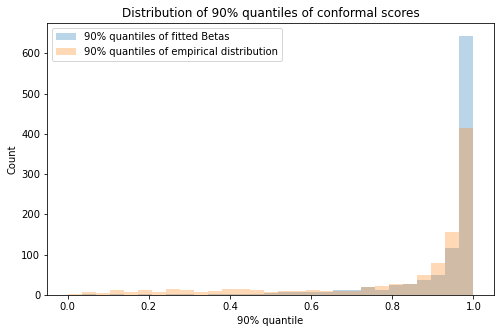

In [195]:
# Compare this to quantiles estimated without using Beta distribution
empirical_quantiles = np.load('/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/empirical_quantiles_alpha=0.1.npy')

plt.figure(figsize=(8,5))
plt.hist(quantiles, bins=bins, alpha= 0.3, label='90% quantiles of fitted Betas')
plt.hist(empirical_quantiles, bins=bins, alpha= 0.3, label='90% quantiles of empirical distribution')
plt.xlabel('90% quantile')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of 90% quantiles of conformal scores')
plt.show()

# Save output

We now create an 1000 x 2 array where row i = [# of times class i appears in validation set, # of times class i is included to conformal set prediction when class i is true label]. Note that the second element is equal to (# of times class i appears in validation set)*(observed class coverage under standard conformal inference).

This array will be fed into the `deconvolveR` package to estimate the distribution of class coverage under standard conformal inference

In [ ]:
# # Count the number of instances of each class in the validation set
# class_cts = Counter(val_labels)

# # Create array
# X = np.zeros((1000,2))
# for i in range(len(X)):
#     X[i,:] = [class_cts[i], class_cts[i]*cb_class_specific_cov[i]]
    
# # Save array
# save_to = "data/standard_conformal_class_coverage.csv"
# np.savetxt(save_to, X, delimiter=",")
# print(f'Saved array to {save_to}')

Save the cutoffs (quantiles) for each class, as well as the class-specific coverages. This is used to create the json file that I use to create https://observablehq.com/d/5bb27b3940f0bc23

In [ ]:
# save_to = '/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_balanced_qhats_INtrain.npy'
# np.save(save_to, qhats)
# print(f'Saved array of qhats to {save_to}')

In [ ]:
# save_to = '/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/class_specific_coverages_INtrain.npy'
# np.save(save_to, cb_class_specific_cov)
# print(f'Saved class-specific coverages to {save_to}')

## Do semantically similar classes have similar qhats? 

Method for computing graph distance:https://www.quora.com/Whatll-be-the-best-method-to-find-the-distances-between-every-two-nodes-in-a-node-tree
```
Now given any two nodes A and B, we can find their deepest common ancestor with the following algorithm:

If the depth of A is greater than the depth of B, find the common ancestor of parent(A) and B.
Otherwise if the depth of B is greater than the depth of A, find the common ancestor of A and parent(B).
Otherwise, if A and B are the same node, then A is the deepest common ancestor.
Otherwise, find the common ancestor of parent(A) and parent(B).
Once you have the deepest common ancestor, C, the distance between A and B is:

depth(A) + depth(B) - 2* depth(C)
```

In [ ]:
hier_info_path = 'data/imagenet_hierarchy/'
in_hier = ImageNetHierarchy(hier_info_path)

In [ ]:
# Test code for computing depths

# def print_depths(curr_node):
#     '''
#     Prints depths of children of current node
#     '''
#     print([f'{c.name}: {c.depth}' for c in curr_node.children])
# #     print([f'{c.depth}' for c in curr_node.children])
#     for c in curr_node.children:
#         print('c', c)
#         print_depths(c)

# root_node = in_hier.get_node("n00001740") 
# print_depths(root_node)

Each list corresponds to the depths of the children of a given node, so we expect the numbers to all be the same. This is generally true, but there are a few weird cases where this is not true. This is possibly because some nodes appear multiple times in ImageNet? Not sure. But I think it not worth spending a lot of time debugging this currently since my code seems operational for the most part. 

In [ ]:
# in_hier.get_node("n00001740").children

In [ ]:
# Sanity checks

node1 = in_hier.get_node("n03814906") # necklace
node2 = in_hier.get_node("n04458633") # totem pole
node3 = in_hier.get_node("n07742313") # Granny Smith
node4 = in_hier.get_node("n07745940") # strawberry

in_hier.get_deepest_common_ancestor(node3, node4)

In [ ]:
print(in_hier.compute_distance(node1, node1)) # Expected answer: 0
print(in_hier.compute_distance(node1, node2)) # Expected answer: 6
print(in_hier.compute_distance(node3, node4)) # Expected answer: 5

### Results

In [ ]:
%%time 

# 1. For all leaf nodes, compute graph distance and difference between qhats. Then calculate correlation

leaf_nodes = [node for node in in_hier.tree if in_hier.get_node(node).descendant_count_in == 0]

all_combinations = sum([[(n1, n2) for n1 in leaf_nodes] for n2 in leaf_nodes], [])
all_combinations = [(n1, n2) for n1, n2 in all_combinations if n1 != n2] # Filter out n1 == n2

dists = [in_hier.compute_distance(in_hier.get_node(n1), in_hier.get_node(n2)) for n1, n2 in all_combinations]
qhat_diffs = [abs(qhats[in_hier.get_node(n1).class_num] - qhats[in_hier.get_node(n2).class_num])
              for n1, n2 in all_combinations]

In [ ]:
dists = np.array(dists)
qhat_diffs = np.array(qhat_diffs)

np.corrcoef(dists, qhat_diffs)

# For ImageNet val:
# array([[1.        , 0.04959895],
#        [0.04959895, 1.        ]])

In [ ]:
# 2. Compare qhat differences between siblings (distance == 2) vs. between other between non-sibling nodes

sibling_idx = [idx for idx in range(len(dists)) if dists[idx] == 2]

sib_diffs = qhat_diffs[sibling_idx]
nonsib_diffs = qhat_diffs[[idx for idx in range(len(dists)) if idx not in sibling_idx]]

In [ ]:
n = len(sib_diffs)
print(f'Mean qhat difference for sibling nodes: {np.mean(sib_diffs):.3f} (std dev: {np.std(sib_diffs) / np.sqrt(n):.3f})')
print(f'Mean qhat difference for non-sibling nodes: {np.mean(nonsib_diffs):.3f} (std dev: {np.std(nonsib_diffs) / np.sqrt(n):.3f})')

# # For ImageNet val:
# Mean qhat difference for sibling nodes: 0.217 (std dev: 0.005)
# Mean qhat difference for non-sibling nodes: 0.245 (std dev: 0.006)

**Conclusion**: Semantically similar classes do not seem to have qhat values that are close to each other